In [44]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchvision import datasets
from torchvision.transforms import v2
from torchsummary import summary

torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [78]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(28, 28), antialias=True),
    # v2.RandomHorizontalFlip(p=0.5),
    # v2.RandomInvert(), # инвертирование цветов
    v2.Grayscale(),
    v2.ToImage(),  # Преобразование в изображение
    v2.ToDtype(torch.float32, scale=True),  # Преобразование в тензор с масштабированием
    # v2.Normalize((0.5,), (0.5,))
])
mnist = datasets.MNIST(root='../data', train=True, download=True, transform=transforms)
mnist_testset = datasets.MNIST(root='../data', train=False, download=True, transform=transforms)

cifar = datasets.CIFAR10(root='../data', train=True, download=True, transform=transforms)
cifar_testset = datasets.CIFAR10(root='../data', train=False, download=True, transform=transforms)

Files already downloaded and verified
Files already downloaded and verified


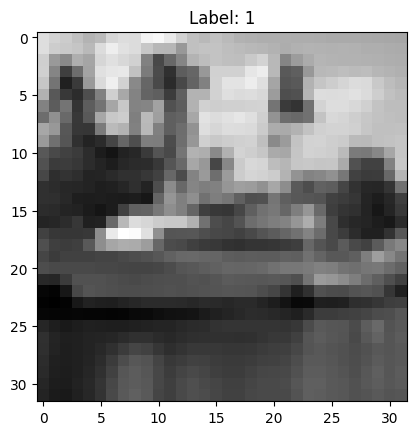

In [110]:
train_loader = torch.utils.data.DataLoader(cifar, batch_size=1024//2, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=1024//2, shuffle=False)

for images, labels in train_loader:
    # Преобразование тензора в numpy массив
    img = images[0].permute(1, 2, 0).numpy()  # Изменение порядка осей для корректного отображения
    plt.imshow(img, cmap='gray')
    plt.title(f'Label: {labels[-1]}')
    plt.show()
    break

In [126]:
class MLP(nn.Module):
    def __init__(self, H, W, hidden_size, output_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
                nn.Linear(H*W, hidden_size * 128),
                nn.ReLU(),
                nn.Linear(hidden_size * 128, hidden_size * 32),
                nn.ReLU(),
                nn.Linear(hidden_size * 32, hidden_size * 8),
                nn.ReLU(),
                nn.Linear(hidden_size * 8, output_size)
        )

    def forward(self, image):
        out = image.view(image.size(0), -1)
        out = self.model(out)
        return out

if __name__ == "__main__":
    batch, S, H, W = 1, 1, 28, 28
    noise = torch.randn((batch, S, H, W)).to(device)
    HIDDEN_SIZE = 16
    OUTPUT_SIZE = 10
    model = MLP(H, W, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
    assert model(noise).shape == torch.Size([1, 10]), 'Fail!'

H, W = 28, 28
HIDDEN_SIZE = 32
OUTPUT_SIZE = 10

mnist_model = MLP(H, W, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
criterion = nn.CrossEntropyLoss()
optimizer  = optim.SGD(model.parameters(), lr=0.05)

summary(mnist_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]       3,215,360
              ReLU-2                 [-1, 4096]               0
            Linear-3                 [-1, 1024]       4,195,328
              ReLU-4                 [-1, 1024]               0
            Linear-5                  [-1, 256]         262,400
              ReLU-6                  [-1, 256]               0
            Linear-7                   [-1, 10]           2,570
Total params: 7,675,658
Trainable params: 7,675,658
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 29.28
Estimated Total Size (MB): 29.37
----------------------------------------------------------------


In [47]:
num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f'Epoch [{epoch+1:>2}/{num_epochs}]') as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'mnist loss': f'{loss.item():.4f}'})
            pbar.update(1)

    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    print(f'Epoch [{epoch+1:>2}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

Epoch [ 1/10]: 100%|██████████| 118/118 [00:21<00:00,  5.42it/s, mnist loss=0.4500]


Epoch [ 1/10], Loss: 1.0396, Accuracy: 73.59%


Epoch [ 2/10]: 100%|██████████| 118/118 [00:21<00:00,  5.40it/s, mnist loss=0.3595]


Epoch [ 2/10], Loss: 0.4142, Accuracy: 88.13%


Epoch [ 3/10]: 100%|██████████| 118/118 [00:21<00:00,  5.47it/s, mnist loss=0.2884]


Epoch [ 3/10], Loss: 0.3584, Accuracy: 89.72%


Epoch [ 4/10]: 100%|██████████| 118/118 [00:22<00:00,  5.32it/s, mnist loss=0.2029]


Epoch [ 4/10], Loss: 0.3343, Accuracy: 90.28%


Epoch [ 5/10]: 100%|██████████| 118/118 [00:22<00:00,  5.35it/s, mnist loss=0.4305]


Epoch [ 5/10], Loss: 0.3228, Accuracy: 90.68%


Epoch [ 6/10]: 100%|██████████| 118/118 [00:21<00:00,  5.42it/s, mnist loss=0.1938]


Epoch [ 6/10], Loss: 0.3144, Accuracy: 90.93%


Epoch [ 7/10]: 100%|██████████| 118/118 [00:22<00:00,  5.30it/s, mnist loss=0.3302]


Epoch [ 7/10], Loss: 0.3077, Accuracy: 91.12%


Epoch [ 8/10]: 100%|██████████| 118/118 [00:21<00:00,  5.46it/s, mnist loss=0.3614]


Epoch [ 8/10], Loss: 0.3056, Accuracy: 91.25%


Epoch [ 9/10]: 100%|██████████| 118/118 [00:21<00:00,  5.42it/s, mnist loss=0.3300]


Epoch [ 9/10], Loss: 0.3001, Accuracy: 91.35%


Epoch [10/10]: 100%|██████████| 118/118 [00:21<00:00,  5.41it/s, mnist loss=0.3688]

Epoch [10/10], Loss: 0.2966, Accuracy: 91.58%


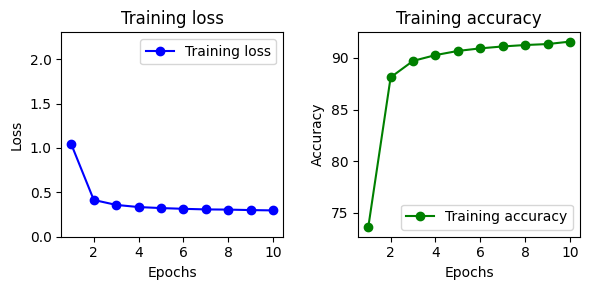

In [52]:
# Визуализация
epochs = range(1, num_epochs+1)

plt.figure(figsize=(6, 3))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, (-np.log(1/10)))
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'go-', label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

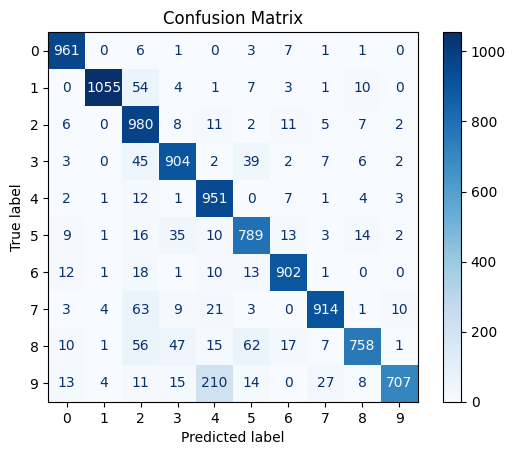

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.99      0.93      0.96      1135
           2       0.78      0.95      0.85      1032
           3       0.88      0.90      0.89      1010
           4       0.77      0.97      0.86       982
           5       0.85      0.88      0.87       892
           6       0.94      0.94      0.94       958
           7       0.95      0.89      0.92      1028
           8       0.94      0.78      0.85       974
           9       0.97      0.70      0.81      1009

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



In [53]:
# Оценка модели на тестовых данных
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Матрица неточностей
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Отчет о классификации
print(classification_report(all_labels, all_predictions, target_names=[str(i) for i in range(10)]))

### **CIFAR-10**

In [129]:
H, W = 32, 32
HIDDEN_SIZE = 64
OUTPUT_SIZE = 10

cifar10_model = MLP(H, W, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
criterion = nn.CrossEntropyLoss()
optimizer  = optim.SGD(cifar10_model.parameters(), lr=0.05)

summary(cifar10_model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 8192]       8,396,800
              ReLU-2                 [-1, 8192]               0
            Linear-3                 [-1, 2048]      16,779,264
              ReLU-4                 [-1, 2048]               0
            Linear-5                  [-1, 512]       1,049,088
              ReLU-6                  [-1, 512]               0
            Linear-7                   [-1, 10]           5,130
Total params: 26,230,282
Trainable params: 26,230,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 100.06
Estimated Total Size (MB): 100.23
----------------------------------------------------------------


In [136]:
num_epochs = 1
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    cifar10_model.train()
    total_loss = 0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f'Epoch [{epoch+1:>{len(str(num_epochs))}}/{num_epochs}]') as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = cifar10_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'CIFAR-10 loss': f'{loss.item():.4f}'})
            pbar.update(1)

    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    print(f'Epoch [{epoch+1:>{len(str(num_epochs))}}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

Epoch [1/1]: 100%|██████████| 98/98 [00:17<00:00,  5.49it/s, CIFAR-10 loss=1.9024]

Epoch [1/1], Loss: 1.7678, Accuracy: 37.34%


In [ ]:
# Визуализация
epochs = range(1, num_epochs+1)

plt.figure(figsize=(6, 3))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, (-np.log(1/10)))
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'go-', label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

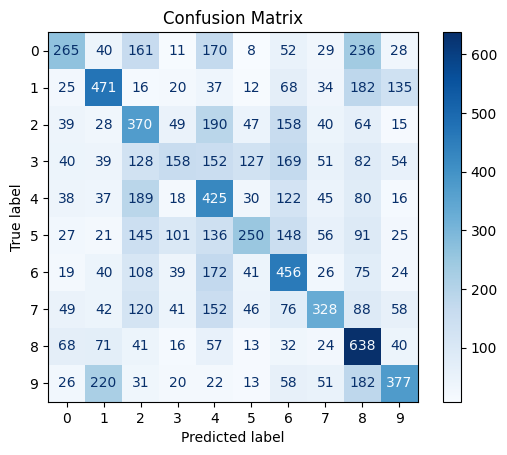

              precision    recall  f1-score   support

           0       0.44      0.27      0.33      1000
           1       0.47      0.47      0.47      1000
           2       0.28      0.37      0.32      1000
           3       0.33      0.16      0.21      1000
           4       0.28      0.42      0.34      1000
           5       0.43      0.25      0.32      1000
           6       0.34      0.46      0.39      1000
           7       0.48      0.33      0.39      1000
           8       0.37      0.64      0.47      1000
           9       0.49      0.38      0.43      1000

    accuracy                           0.37     10000
   macro avg       0.39      0.37      0.37     10000
weighted avg       0.39      0.37      0.37     10000



In [139]:
# Оценка модели на тестовых данных
cifar10_model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cifar10_model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Матрица неточностей
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Отчет о классификации
print(classification_report(all_labels, all_predictions, target_names=[str(i) for i in range(10)]))